In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
m_crs = 'EPSG:26910'
ll_crs = 'EPSG:4326'

In [3]:
benthic = gpd.read_file('clean_data/benthic/benthic_substrates.shp')

In [4]:
coastline = gpd.read_file('clean_data/coastline/mainland_coast.shp') # linestring gdf
ocean = gpd.read_file('clean_data/coastline/small_coast.shp') # for plotting

counties = gpd.read_file('raw_datasets/ca_counties/ca_counties.shp').to_crs(ll_crs)
keys = ['sd', 'ora', 'la', 'ven', 'sb', 'slo', 'mon', 'scr']
county_keys = {'sd': 'San Diego',
               'ora': 'Orange',
               'la': 'Los Angeles',
               'ven': 'Ventura',
               'sb': 'Santa Barbara',
               'slo': 'San Luis Obispo',
               'mon': 'Monterey',
               'scr': 'Santa Cruz'}
county_names = [county_keys[key] for key in keys]
counties = counties.loc[[(name in county_names) for name in counties.NAME]].reset_index(drop=True)

In [5]:
# relevant reefs are hard substrate from 0-100m depth, where recreational fishing might potentially occur
rocks = benthic.loc[(benthic.Sub == 'Hard') & (benthic.zone.isin(['0 - 30m', '30 - 100m']))].reset_index(drop=True)

In [6]:
rocks.head()

,X,Y,zone,Sub,Shp_Lng,Shap_Ar,geometry
0,117° 30.000' W,32° 30.000' N,0 - 30m,Hard,3.708466e+06,2.948578e+07,"MULTIPOLYGON (((-117.18346 32.53525, -117.1834..."
1,117° 30.000' W,32° 30.000' N,30 - 100m,Hard,2.396943e+06,9.975115e+06,"MULTIPOLYGON (((-117.18445 32.53172, -117.1844..."
2,117° 30.000' W,33° 30.000' N,0 - 30m,Hard,3.558815e+05,6.719849e+06,"MULTIPOLYGON (((-117.28927 33.00091, -117.2893..."
3,117° 30.000' W,33° 30.000' N,30 - 100m,Hard,1.983232e+05,6.995900e+05,"MULTIPOLYGON (((-117.31341 33.00092, -117.3134..."
4,118° 30.000' W,32° 30.000' N,0 - 30m,Hard,5.504301e+05,2.358881e+07,"MULTIPOLYGON (((-118.41532 32.79961, -118.4153..."


# split reefs up and subset for within study region and within 5km of the coastline

In [7]:
ex = rocks.filter(['zone', 'Sub', 'geometry']).explode().reset_index(drop=True)

In [8]:
# filter for only reefs within this square
from shapely.geometry import Polygon

coords = [(-122.5,37.5), (-122.5,32.4), (-116,32.4), (-116,37.5)]
polygon = Polygon(coords)

# Create a GeoDataFrame to handle and visualize the Polygon
gdf = gpd.GeoDataFrame({'geometry': [polygon]})

# Set a Coordinate Reference System (CRS) if necessary (e.g., EPSG:4326 for lat/lon)
gdf = gdf.set_crs(ll_crs)
gdf = gdf.to_crs(ex.crs)

# filter reefs within target region
within_target = ex.geometry.intersects(gdf.geometry[0])
ex = ex.loc[within_target].reset_index(drop=True)

In [9]:
# make a 5km buffer from the coastline and only keep reefs there
coastline = coastline.to_crs(m_crs)
buffer = coastline.geometry[0].buffer(5 * 1000)

ex = ex.to_crs(coastline.crs)
within_buffer = ex.geometry.intersects(buffer)
ex = ex.loc[ex.geometry.intersects(buffer)].reset_index(drop=True)

In [10]:
ex = ex.to_crs(ll_crs)
coastline = coastline.to_crs(ex.crs)
len(ex)

450576

In [11]:
'''fig, ax = plt.subplots(figsize=(10,10))

counties.plot(ax=ax, color='red', alpha=0.5)
ocean.plot(ax=ax, color = 'lightblue')
coastline.plot(ax=ax, color='white', linewidth=1)

ex.plot(ax=ax, color = 'gray')'''

"fig, ax = plt.subplots(figsize=(10,10))\n\ncounties.plot(ax=ax, color='red', alpha=0.5)\nocean.plot(ax=ax, color = 'lightblue')\ncoastline.plot(ax=ax, color='white', linewidth=1)\n\nex.plot(ax=ax, color = 'gray')"

# simplify remaining geometries using the Ramer–Douglas–Peucker algorithm (shapely.simplify()

In [12]:
g = ex.geometry[11]

In [13]:
g.area

4.803430322806675e-09

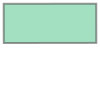

In [14]:
g

In [15]:
from shapely import simplify

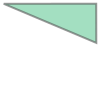

In [16]:
simplify(g, 5)

In [17]:
# simplify within tolerance 5m
from shapely import simplify
simple = ex.copy().to_crs(m_crs)

epsilon = 5 # 5m tolerance
simple.geometry = ex.geometry.apply(lambda g: simplify(g, epsilon))

In [18]:
simple = simple.to_crs(ll_crs)

<Axes: >

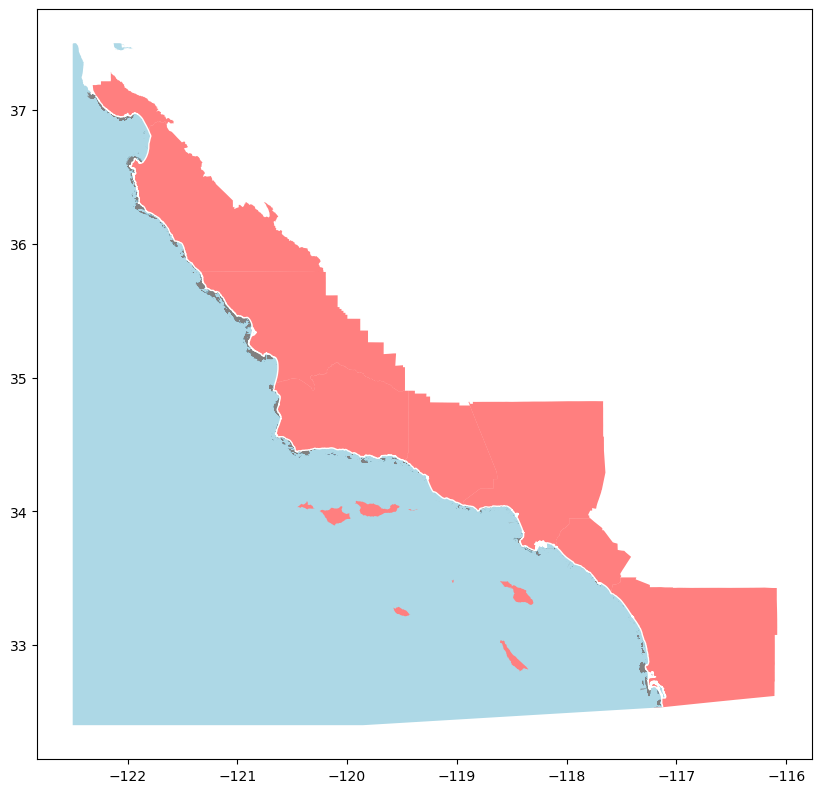

In [19]:
fig, ax = plt.subplots(figsize=(10,10))

counties.plot(ax=ax, color='red', alpha=0.5)
ocean.plot(ax=ax, color = 'lightblue')
coastline.plot(ax=ax, color='white', linewidth=1)

simple.plot(ax=ax, color = 'gray')

In [20]:
ex_num_vertices = [ex.geometry.apply(lambda g: len(g.exterior.coords))]

In [21]:
simple_num_vertices = [simple.geometry.apply(lambda g: len(g.exterior.coords))]

In [22]:
np.mean(ex_num_vertices)

27.91328876815454

In [23]:
np.mean(simple_num_vertices)

4.20909458115834

# further simplify geometry with buffer method

In [24]:
# buffer is at 200m
simple = simple.to_crs(m_crs)

In [25]:
simple_buffer = simple.geometry.apply(lambda g: g.buffer(200))

In [26]:
simple_buffer_union = simple_buffer.union_all()

In [27]:
simple_buffer =gpd.GeoDataFrame(geometry=[simple_buffer_union], crs = simple.crs)

In [28]:
simple_buffer_exploded = simple_buffer.explode()

In [29]:
len(simple_buffer_exploded)

486

In [30]:
simple_buffer_exploded.head()

,geometry
0,"POLYGON ((559233.048 4104329.171, 559217.283 4..."
0,"POLYGON ((576468.529 4089385.949, 576463.345 4..."
0,"POLYGON ((575818.471 4090940.96, 575831.435 40..."
0,"POLYGON ((572641.175 4092507.334, 572622.136 4..."
0,"POLYGON ((577831.525 4086810.027, 577846.342 4..."


In [31]:
simple_buffer_exploded = simple_buffer_exploded.reset_index(drop=True).reset_index()

In [32]:
simple_buffer_exploded.columns = ['reef_id', 'geometry']

In [62]:
simple_buffer_exploded.head()

,reef_id,geometry
0,0,"POLYGON ((-122.33356 37.08338, -122.33374 37.0..."
1,1,"POLYGON ((-122.14117 36.94744, -122.14123 36.9..."
2,2,"POLYGON ((-122.14832 36.96151, -122.14817 36.9..."
3,3,"POLYGON ((-122.18386 36.97588, -122.18407 36.9..."
4,4,"POLYGON ((-122.12613 36.92411, -122.12597 36.9..."


In [63]:
simple_num_vertices = [simple.geometry.apply(lambda g: len(g.exterior.coords))]

# get the area of hard benthic substrate at each location

In [64]:
centroids = ex.to_crs(m_crs)

In [65]:
centroids['area_m2'] = centroids.geometry.area

In [66]:
centroids.geometry = centroids.geometry.centroid

In [67]:
centroids.head()

,zone,Sub,geometry,area_m2
0,0 - 30m,Hard,POINT (1047148.307 3614993.61),50.370042
1,0 - 30m,Hard,POINT (1047202.855 3615006.746),100.739730
2,0 - 30m,Hard,POINT (1047175.156 3615007.693),50.370617
3,0 - 30m,Hard,POINT (1047019.124 3615011.44),25.185437
4,0 - 30m,Hard,POINT (1047207.299 3615017.05),100.740480


In [68]:
centroids = centroids.to_crs(ll_crs)
simple_buffer_exploded = simple_buffer_exploded.to_crs(centroids.crs)

centroids['reef_id'] = [None] * len(centroids)
for i,g in enumerate(centroids.geometry):
    for j,(reef, rid) in enumerate(zip(simple_buffer_exploded.geometry,simple_buffer_exploded.reef_id)):
        if g.intersects(reef):
            centroids.loc[i, 'reef_id'] = rid

In [69]:
centroids.reef_id.isna().sum(), centroids.reef_id.isna().mean()

(3, 6.6581442420368595e-06)

In [70]:
centroids.loc[centroids.reef_id.isna()]

,zone,Sub,geometry,area_m2,reef_id
83569,0 - 30m,Hard,POINT (-119.9747 34.4432),8.570034e+05,None
113469,0 - 30m,Hard,POINT (-120.03385 34.45993),5.929724e+05,None
370117,0 - 30m,Hard,POINT (-121.93278 36.63379),3.179762e+06,None


In [71]:
c = centroids.geometry.loc[83569]

In [72]:
c.distance(simple_buffer_exploded.geometry[0])

3.1873056535209767

In [125]:
missing_ids = pd.DataFrame({'centroid_ids': centroids.loc[centroids.reef_id.isna()].index})
missing_ids['reef_id'] = [np.nan] * len(centroids.loc[centroids.reef_id.isna()].index)
missing_ids.centroid_ids = missing_ids.centroid_ids.astype(int)
missing_ids = missing_ids.set_index('centroid_ids')

In [126]:
for idx in missing_ids.index:
    
    g = centroids.geometry.iloc[idx]
    distances = simple_buffer_exploded.geometry.apply(lambda p: g.distance(p))
    rid_min_dist = float(simple_buffer_exploded.reef_id.loc[distances == distances.min()].iloc[0])

    missing_ids.loc[idx, 'reef_id'] = rid_min_dist
    
missing_ids

,reef_id
centroid_ids,
83569,170.0
113469,161.0
370117,10.0


In [133]:
cent = centroids.copy()

In [137]:
for idx,rid in zip(missing_ids.index, missing_ids.reef_id):
    cent.loc[idx, 'reef_id'] = rid

In [140]:
cent.reef_id.isna().sum(), cent.reef_id.isna().mean()

(0, 0.0)

# save simplified shapefiles

In [141]:
# distinct reefs
simple_buffer_exploded.to_file('clean_data/benthic_simplified/benthic_simplified.shp')

In [142]:
# points and reef area
cent.to_file('clean_data/benthic_simplified/centroids.shp')